## Up to this point!

We have attempted to answer Question 1 as a regression problem.  That would assume target values are continous - that is they can be just about any floating number.  This first became obvious when we compared predicted values (3.67, 3.78, 4.12, 4.87) to our actual target values (3.0, 4.0, 4.5, 5.0).  In fact, our target values are constant.

The only values allowed are (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0).  This would seem to change things, instead of treating this as a regression problem, this notebook will now instead treat this as a classification problem.  Takeaway here is to be careful when deciding upon which type of problem you are solving.  Numbers are not always numbers.  

Classification tends to take certain forms:

* Gender - (Male, Female, Unknown)
* Color - (Red, Blue, Green)
* Temperature (Cold, Windy, Snowing)

but in our case of review_overall the set looks like this: (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0)

We'll start by loading up the tools needed and then go deeper into exploring this Question as a classification problem and see if we can better answer the Question:

`Is there a steady relationship between appearance, aroma, taste across different beer styles - can an overall rating be predicted based on training data from a given beer style against a different distinct beer style.`

In [1]:
# import what we will be using
from __future__ import print_function

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans,DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.cluster import silhouette_score
#from sklearn.metrics import mean_squared_error, accuracy_score
import scipy.stats as stats

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import os

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

Define Functions we will be using next

In [2]:
'''
want to keep row count to a reasonable number - would not do this in a real life scenario but
for purposes of what is happening here... being able to run this stuff quickly allows
more time for the important stuff -- actual coding and learning
'''
def trimDataRows(df, rowcount):
    srRand = pd.Series(np.random.randint(df.shape[0], size=rowcount))
    dfMerge = srRand.to_frame()

    # hack a dummy column
    dfMerge['dummy'] = ""
    dfMerge.set_index(0, inplace=True)

    # merge to get 5 random beer_styles
    df = dfMerge.merge(df, how="inner", left_index=True, right_index=True)
    # drop dummy
    try:
        df.drop('dummy_x', axis=1, inplace=True)
        df.drop('dummy_y', axis=1, inplace=True)
    except:
        pass

    return df

# define a function to scale predicted results to .5 intervals
def scale_to_nearest_half_int(x):
    return round(x * 2) / 2

def scale_predictions(X):
    for i in range(0,X.size):
        X[i] = scale_to_nearest_half_int(X[i])        
    return X

# define a function to build and return test results
def build_test_results(lst, testType, pred, actual, scale_pred):
    score = metrics.r2_score(pred, actual)
    mae = metrics.mean_absolute_error(pred, actual)
    mse = metrics.mean_squared_error(pred, actual)
    rmse = np.sqrt(metrics.mean_squared_error(pred, actual))
    
    # add to lst
    lst.append({"test": testType, "R2Score": score, "MAE": mae, "mse" : mse, "RMSE" : rmse})
    
    if scale_pred:
        pred_scaled = scale_predictions(pred)
        #some recursion
        build_test_results(lst, testType + " (scaled)", pred_scaled, actual,False)
    
    return lst

Declare and instantiate any globals to be used throughout this notebook

In [86]:
# load the data and take a quick peek - we will use the beer_style summary we created previously
beer_styles = pd.read_csv("../data/beer_style_summary.csv")
beer_styles.shape

(104, 19)

In [5]:
# so 104 rows... let's build 2 separate lists to hold unique beer styles for test and train data

# start by generating 10 random ints 
aryRand = np.random.randint(104, size=10)

# next... convert this array to a series... take head/tail to form our actual indexes of beer style
srRand = pd.Series(aryRand)
dfTop5 = srRand.head().to_frame()
# hack a dummy column
dfTop5['dummy'] = ""
dfTop5.set_index(0, inplace=True)
# merge to get 5 random beer_styles
dfTop5 = dfTop5.merge(beer_styles, how="inner", left_index=True, right_index=True)

# do it all over for train
dfBottom5 = srRand.tail().to_frame()
# hack a dummy column
dfBottom5['dummy'] = ""
dfBottom5.set_index(0, inplace=True)
# merge to get 5 random beer_styles
dfBottom5 = dfBottom5.merge(beer_styles, how="inner", left_index=True, right_index=True)

print ('dfTop5\n', dfTop5['beer_style'])
print ('\n')
print ('dfBottom5\n', dfBottom5['beer_style'])

dfTop5
 51                English Strong Ale
14           American Pale Ale (APA)
33    California Common / Steam Beer
30                       Black & Tan
98                            Tripel
Name: beer_style, dtype: object


dfBottom5
 63                                Gueuze
51                    English Strong Ale
81                   Munich Helles Lager
10    American Double / Imperial Pilsner
95                          Scottish Ale
Name: beer_style, dtype: object


In [6]:
# load all beer reviews
beer_reviews = pd.read_csv("../data/beer_reviews.csv")
beer_reviews.shape

(1586614, 13)

In [87]:
# first for test
dfTest = dfTop5.merge(beer_reviews, on="beer_style")
dfTest.shape

(104992, 32)

In [88]:
# now for train
dfTrain = dfBottom5.merge(beer_reviews, on="beer_style")
dfTrain.shape

(33246, 32)

In [89]:
dfTrain = trimDataRows(dfTrain, 25000)
dfTest = trimDataRows(dfTest, 25000)

dfTest.head()

,beer_style,number_of_distinct_reviewers,number_of_distinct_brewerys,number_of_distinct_beer,total_brewerys,pct_brewerys,mean_distinct_brewerys,sd_distinct_brewerys,Z_distinct_brewerys,total_reviewers,...,review_time,review_overall,review_aroma,review_appearance,review_profilename,review_palate,review_taste,beer_name,beer_abv,beer_beerid
2,English Strong Ale,2217,229,299,5742,0.039882,411.259615,346.078418,-0.526643,33387,...,1294015618,5.0,4.0,4.5,JamesS,4.0,4.5,Limping Mallard,7.7,63460
5,English Strong Ale,2217,229,299,5742,0.039882,411.259615,346.078418,-0.526643,33387,...,1292279279,5.0,4.5,5.0,JamesS,4.0,4.0,Bigger Boy's Beer,8.4,63020
14,English Strong Ale,2217,229,299,5742,0.039882,411.259615,346.078418,-0.526643,33387,...,1316836196,3.5,4.0,4.0,Berrmecca13,3.0,3.5,Otro Mundo Strong Red Ale,7.5,40765
14,English Strong Ale,2217,229,299,5742,0.039882,411.259615,346.078418,-0.526643,33387,...,1316836196,3.5,4.0,4.0,Berrmecca13,3.0,3.5,Otro Mundo Strong Red Ale,7.5,40765
23,English Strong Ale,2217,229,299,5742,0.039882,411.259615,346.078418,-0.526643,33387,...,1289853537,2.5,2.5,2.5,Tone,3.5,3.0,Otro Mundo Strong Red Ale,7.5,40765


In [90]:
dfTrain.head()

,beer_style,number_of_distinct_reviewers,number_of_distinct_brewerys,number_of_distinct_beer,total_brewerys,pct_brewerys,mean_distinct_brewerys,sd_distinct_brewerys,Z_distinct_brewerys,total_reviewers,...,review_time,review_overall,review_aroma,review_appearance,review_profilename,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,Gueuze,2004,36,93,5742,0.00627,411.259615,346.078418,-1.08432,33387,...,1323537615,4.5,4.5,4.0,HopHead84,3.5,4.0,Batch 50: Grand Funk Ale Road,5.8,75559
2,Gueuze,2004,36,93,5742,0.00627,411.259615,346.078418,-1.08432,33387,...,1325913428,3.5,4.0,3.5,callmemickey,3.5,3.5,Batch 50: Grand Funk Ale Road,5.8,75559
3,Gueuze,2004,36,93,5742,0.00627,411.259615,346.078418,-1.08432,33387,...,1325874244,4.0,4.0,3.5,Sean9689,3.5,4.0,Batch 50: Grand Funk Ale Road,5.8,75559
7,Gueuze,2004,36,93,5742,0.00627,411.259615,346.078418,-1.08432,33387,...,1323887472,4.0,3.5,2.5,billshmeinke,3.0,4.0,Batch 50: Grand Funk Ale Road,5.8,75559
9,Gueuze,2004,36,93,5742,0.00627,411.259615,346.078418,-1.08432,33387,...,1323150270,4.0,4.0,4.5,CharlieMurphy,4.0,3.5,Batch 50: Grand Funk Ale Road,5.8,75559


In [11]:
# pick our feature/predictor list(s)
X_variable = list(['review_appearance','review_taste','review_aroma'])
y_variable = list(['review_overall'])

print('X_variable:\t', X_variable)
print('y_variable:\t', y_variable)

X_variable:	 ['review_appearance', 'review_taste', 'review_aroma']
y_variable:	 ['review_overall']


## K-Means Clustering

Let's start with some clustering and see how that might relate to our fixed set of target values

Recall target values are a fixed set of numbers: (1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0)

9 distinct values - does that mean we should expect 9 distinct clusters?... I think not but lets find out

In [14]:
# so start with 9 clusters - after all we do have 9 target values
kmeans = KMeans(n_clusters=9,random_state=1234)
kmeans.fit(dfTrain[X_variable])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [34]:
# add a column for how things were clustered... then do a quick sanity review
dfTrain["kmeans_2"] = ["cluster_"+str(label) for label in kmeans.labels_]

print('Unique values for cluster 1:\t', dfTrain[dfTrain.kmeans_2 == "cluster_0"].review_overall.unique())
print('Unique values for cluster 2:\t', dfTrain[dfTrain.kmeans_2 == "cluster_1"].review_overall.unique())
print('Unique values for cluster 3:\t', dfTrain[dfTrain.kmeans_2 == "cluster_2"].review_overall.unique())
print('Unique values for cluster 4:\t', dfTrain[dfTrain.kmeans_2 == "cluster_3"].review_overall.unique())
print('Unique values for cluster 5:\t', dfTrain[dfTrain.kmeans_2 == "cluster_4"].review_overall.unique())
print('Unique values for cluster 6:\t', dfTrain[dfTrain.kmeans_2 == "cluster_5"].review_overall.unique())
print('Unique values for cluster 7:\t', dfTrain[dfTrain.kmeans_2 == "cluster_6"].review_overall.unique())
print('Unique values for cluster 8:\t', dfTrain[dfTrain.kmeans_2 == "cluster_7"].review_overall.unique())
print('Unique values for cluster 9:\t', dfTrain[dfTrain.kmeans_2 == "cluster_8"].review_overall.unique())

Unique values for cluster 1:	 [ 3.   2.5  2.   1.5  4.   1.   3.5  5.   4.5]
Unique values for cluster 2:	 [ 3.   4.   4.5  3.5  5.   2.   2.5]
Unique values for cluster 3:	 [ 3.5  4.5  4.   3.   2.5  5.   2.   1. ]
Unique values for cluster 4:	 [ 1.   1.5  2.   2.5  3.   4.   3.5  4.5  5. ]
Unique values for cluster 5:	 [ 2.5  3.   3.5  4.   2.   4.5  1.5  5. ]
Unique values for cluster 6:	 [ 3.5  4.   4.5  3.   2.   5.   2.5]
Unique values for cluster 7:	 [ 3.   2.5  2.   1.5  1.   4.   3.5  5.   4.5]
Unique values for cluster 8:	 [ 4.5  4.   5.   3.5  3.   2.5]
Unique values for cluster 9:	 [ 2.5  3.5  3.   4.   2.   4.5  1.   5.   1.5]


wow - that's all over the place - not what we might have expected... how does this look visually?

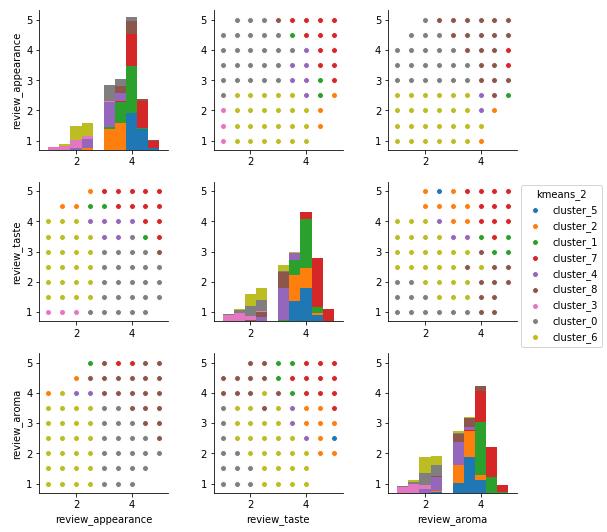

In [53]:
# usin list(X_variable) as opposed to simply assigning X_variable creates a new list (empty and then appends X_variable)
plot_vars = list(X_variable)
plot_vars.append('kmeans_2')

sns.pairplot(dfTrain[plot_vars],hue="kmeans_2")

this seems a bit busy and from what has been gleaned... clustering does not appear to have a great correlation with the target value(s).  what does the Silhoutte Score tell us?

per wikipedia--
`The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters`

so we want a HIGH score

In [59]:
print("Silhouette score:",silhouette_score(dfTrain[X_variable], kmeans.labels_))

Silhouette score: 0.288446307338


so we got .288 and while that is a good distance from -1 it is still a ways off from 1... let's next cycle through a range of clusters and graphically compare scores to see if we can find a better number to use for clustering

Text(0,0.5,u'Silhouette Score')

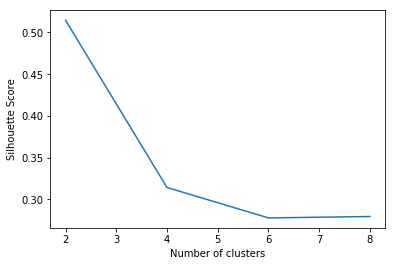

In [63]:
clusters = range(2,9, 2)
scores = list([])

for cluster in clusters:
    km = KMeans(n_clusters=cluster, random_state=1234) 
    km.fit(dfTrain[X_variable])
    scores.append(silhouette_score(dfTrain[X_variable], km.labels_))

# plot the results
sns.mpl.pyplot.plot(clusters, scores)
sns.mpl.pyplot.xlabel('Number of clusters')
sns.mpl.pyplot.ylabel('Silhouette Score')

In [65]:
pd.DataFrame(scores)

,0
0,0.514583
1,0.314353
2,0.277937
3,0.279606


Silhoutte is .514 for 2 clusters, .314 for 3, after 6 it tends to taper off with a slight bump around 8 - recall 9 returned .2884.

Given the nature of where `review_overall` comes from (e.g. on a scale of 1 to 5), I am thinking 3 clusters would be ideal for what we are trying to do here - ultimately we could classify these as good_review (4.0+), poor_review (>3.0) and fair_review (x == 3.0 or x == 3.5)

Let's set clustering to 3 and then again run the same metrics that were ran for clusters=9

In [14]:
km3 = KMeans(n_clusters=3,random_state=1234)
km3.fit(dfTrain[X_variable])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [17]:
# add a column for how things were clustered... then do a quick sanity review
dfTrain["kmeans_3"] = ["cluster_"+str(label) for label in km3.labels_]

print('Unique values for cluster 1:\t', dfTrain[dfTrain.kmeans_3 == "cluster_0"].review_overall.unique())
print('Unique values for cluster 2:\t', dfTrain[dfTrain.kmeans_3 == "cluster_1"].review_overall.unique())
print('Unique values for cluster 3:\t', dfTrain[dfTrain.kmeans_3 == "cluster_2"].review_overall.unique())

Unique values for cluster 1:	 [ 3.5  3.   4.   4.5  2.5  5.   2.   1.5  1. ]
Unique values for cluster 2:	 [ 3.   3.5  2.   4.   5.   2.5  1.   1.5  4.5]
Unique values for cluster 3:	 [ 4.5  4.   5.   3.5  3.   2.5  1.   2. ]


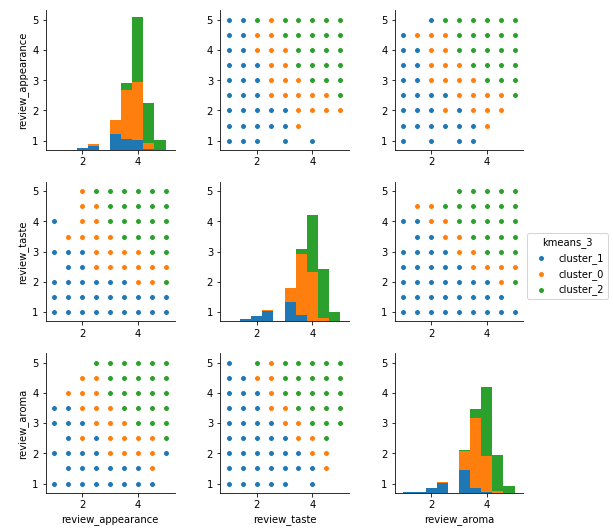

In [18]:
# usin list(X_variable) as opposed to simply assigning X_variable creates a new list (empty and then appends X_variable)
plot_vars = list(X_variable)
plot_vars.append('kmeans_3')

sns.pairplot(dfTrain[plot_vars],hue="kmeans_3")

In [20]:
# and finally the score
silhouette_score(dfTrain[X_variable], km3.labels_)

0.3018499417973517

and while .302 isn't much better than .28 (.5ish could be too close to over-fitting)... as best I can tell things do look better.  Part of this is the data itself no doubt - at the end of the day we are trying to make predictions against subjective data (which can and often is all over the map).  The methodology I think is more important at this point than the end-accuracy - strongly suspect that using all the methods that have been used up to this point only against objective-scientific data against similiar targets would be yielding much different results

## Logistic Regression

so now... will just  create some new columns to our data set (targets) and then run some predictive analysis and see what happens

In [95]:
#good_review (4.0+), poor_review (>3.0) and fair_review (x == 3.0 or x == 3.5)
dfTrain['good_review'] = (dfTrain.review_overall >= 4.0).astype(int)
dfTrain['poor_review'] = (dfTrain.review_overall < 3.0).astype(int)
dfTrain['fair_review'] = (np.logical_and(dfTrain.review_overall >= 3.0, dfTrain.review_overall < 4.0).astype(int))
print('Train\n',dfTrain[['review_overall', 'good_review', 'fair_review', 'poor_review']].head(5))

#good_review (4.0+), poor_review (>3.0) and fair_review (x == 3.0 or x == 3.5)
dfTest['good_review'] = (dfTest.review_overall >= 4.0).astype(int)
dfTest['poor_review'] = (dfTest.review_overall < 3.0).astype(int)
dfTest['fair_review'] = (np.logical_and(dfTest.review_overall >= 3.0, dfTest.review_overall < 4.0).astype(int))
print('Test\n',dfTest[['review_overall', 'good_review', 'fair_review', 'poor_review']].head(5))


Train
    review_overall  good_review  fair_review  poor_review
0             4.5            1            0            0
2             3.5            0            1            0
3             4.0            1            0            0
7             4.0            1            0            0
9             4.0            1            0            0
Test
     review_overall  good_review  fair_review  poor_review
2              5.0            1            0            0
5              5.0            1            0            0
14             3.5            0            1            0
14             3.5            0            1            0
23             2.5            0            0            1


In [92]:
# now for some logistic regression -- but ONLY on training data
logreg = LogisticRegression(C=1e9)
X = dfTrain[X_variable]
y = dfTrain.good_review
logreg.fit(X, y)
pred = logreg.predict(X)

In [93]:
pred

array([1, 0, 1, ..., 0, 0, 0])

In [94]:
# how many predictions were we right about?
print("Model accuracy (no train-test-split):",metrics.accuracy_score(y,pred))

Model accuracy: 0.81344


that is really good... what does it look like on a train-test-split model

In [96]:
# now for some logistic regression
logreg = LogisticRegression(C=1e9)
X = dfTrain[X_variable]
y = dfTrain.good_review
logreg.fit(dfTrain[X_variable], dfTrain.good_review)
pred = logreg.predict(dfTest[X_variable])

In [98]:
# how many predictions were we right about?
print("Model accuracy (with train-test-split):",metrics.accuracy_score(dfTest.good_review,pred))

Model accuracy (with train-test-split): 0.81944


## DecisionTree Classifer

so just for fun... let's try a new toy

In [99]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state=0)
dtc.fit(dfTrain[X_variable], dfTrain.good_review)
pred = dtc.predict(dfTest[X_variable])

In [100]:
# how many predictions were we right about?
print("Model accuracy (with train-test-split):",metrics.accuracy_score(dfTest.good_review,pred))

Model accuracy (with train-test-split): 0.81236


# Back to the initial Question and a final attempt to answer

`Is there a steady relationship between appearance, aroma, taste across different beer styles - can an overall rating be predicted based on training data from a given beer style against a different distinct beer style.`

Just like was done using Linear Regression... we'll start by loading up a singular style and then run the same tests and compare accuracy

In [101]:
# get the top reviewed beer style
max_beer_style = beer_styles.number_of_distinct_reviewers.max()
beer_single_style = beer_styles[beer_styles.number_of_distinct_reviewers == max_beer_style]
beer_single_style

,beer_style,number_of_distinct_reviewers,number_of_distinct_brewerys,number_of_distinct_beer,total_brewerys,pct_brewerys,mean_distinct_brewerys,sd_distinct_brewerys,Z_distinct_brewerys,total_reviewers,pct_reviewers,mean_distinct_reviewers,sd_distinct_reviewers,Z_distinct_reviewers,total_beer,pct_Beer,mean_distinct_beer,sd_distinct_beer,Z_distinct_beer
12,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,0.373798,3870.201923,2442.428826,3.525097,56857,0.055701,566.269231,558.586222,4.655916


In [102]:
# join up with all beer_reviews
beers_for_model = pd.merge(beer_single_style, beer_reviews, how="inner", on=['beer_style'])
print('Shape:\t',beers_for_model.shape)
beers_for_model.head()

Shape:	 (117586, 31)


,beer_style,number_of_distinct_reviewers,number_of_distinct_brewerys,number_of_distinct_beer,total_brewerys,pct_brewerys,mean_distinct_brewerys,sd_distinct_brewerys,Z_distinct_brewerys,total_reviewers,...,review_time,review_overall,review_aroma,review_appearance,review_profilename,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,...,1272945129,4.0,4.0,4.0,Akfan,4.0,4.5,Caldera IPA,6.1,10784
1,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,...,1324238653,4.0,4.0,4.0,coldriver,4.0,4.5,Caldera IPA,6.1,10784
2,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,...,1296875377,4.0,4.0,4.0,Mora2000,4.0,4.0,Caldera IPA,6.1,10784
3,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,...,1297129212,4.0,4.0,4.0,Rutager,4.0,3.5,Caldera IPA,6.1,10784
4,American IPA,12480,1606,3167,5742,0.279693,411.259615,346.078418,3.452224,33387,...,1297105083,4.5,4.0,4.0,CHILLINDYLAN,4.0,4.0,Caldera IPA,6.1,10784


In [103]:
# that's a lotta records... trim it down
dfTrainIPA = trimDataRows(beers_for_model, 25000)
dfTestIPA = trimDataRows(beers_for_model, 25000)

In [108]:
#good_review (4.0+), poor_review (>3.0) and fair_review (x == 3.0 or x == 3.5)
dfTestIPA['good_review'] = (dfTestIPA.review_overall >= 4.0).astype(int)
dfTestIPA['poor_review'] = (dfTestIPA.review_overall < 3.0).astype(int)
dfTestIPA['fair_review'] = (np.logical_and(dfTestIPA.review_overall >= 3.0, dfTestIPA.review_overall < 4.0).astype(int))
print('Test\n',dfTestIPA[['review_overall', 'good_review', 'fair_review', 'poor_review']].head(5))


Test
     review_overall  good_review  fair_review  poor_review
0              4.0            1            0            0
4              4.5            1            0            0
12             5.0            1            0            0
17             4.0            1            0            0
18             3.5            0            1            0


## Logistict Regression (train-test-split)

In [107]:
# now for some logistic regression
logreg = LogisticRegression(C=1e9)
X = dfTrain[X_variable]
y = dfTrain.good_review
logreg.fit(dfTrainIPA[X_variable], dfTrainIPA.good_review)
pred = logreg.predict(dfTestIPA[X_variable])
# how many predictions were we right about?

print("Model accuracy (with train-test-split):",metrics.accuracy_score(dfTestIPA.good_review,pred))

Model accuracy (with train-test-split): 0.84692


## DecisionTree Classifier (train-test-split)

In [109]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state=0)
dtc.fit(dfTrain[X_variable], dfTrain.good_review)
pred = dtc.predict(dfTestIPA[X_variable])

# how many predictions were we right about?
print("Model accuracy (with train-test-split):",metrics.accuracy_score(dfTestIPA.good_review,pred))

Model accuracy (with train-test-split): 0.84232


## Final Assessment

`Is there a steady relationship between appearance, aroma, taste across different beer styles - can an overall rating be predicted based on training data from a given beer style against a different distinct beer style.`

Yes there certainly appears to be

Using Linear Regression proved a bit fruitless in answering this as in no instances was there a high level of predictability.

Using Logistic Regression however provided high levels of predictability against both sets of samples: (across random styles and then using random styles to predict a singular style)